# Почувствуй мощь трансформеров в бою

<b>Цель.</b> Научиться работать с трансформерными моделями и применять их для различных NLP задач.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>
1. В качестве данных выберете возьмите датасет RuCola для русского языка https://github.com/RussianNLP/RuCoLA (в качестве train возьмите in_domain_train.csv, а в качестве теста in_domain_dev.csv).
2. Разбейте in_domain_train на train и val.
3. Зафайнтьюньте и протестируйте RuBert или RuRoBerta на данной задаче (можно взять любую предобученную модель руберт с сайта huggingface. Например, ruBert-base/large https://huggingface.co/sberbank-ai/ruBert-base / https://huggingface.co/sberbank-ai/ruBert-large или rubert-base-cased https://huggingface.co/DeepPavlov/rubert-base-cased, ruRoberta-large https://huggingface.co/sberbank-ai/ruRoberta-large, xlm-roberta-base https://huggingface.co/xlm-roberta-base).
4. Возьмите RuGPT3 base или large и решите данное задание с помощью методов few-/zero-shot:
а) переберите несколько вариантов затравок,
б) протестируйте различное число few-shot примеров (0, 1, 2, 4).
5. Обучите и протестируйте модель RuT5 на данной задаче (пример finetun’а можете найти здесь https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py).
6. Сравните полученные результаты.

# Выполнение

Импортируем основные библиотеки.

In [1]:
import os
import evaluate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from functools import partial
from shutil import rmtree
from razdel import tokenize
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    T5ForConditionalGeneration,
	AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForMaskedLM,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    TrainerCallback,
)

import warnings
from transformers import logging as transformers_logging
from sklearn.exceptions import UndefinedMetricWarning

# Отключение всех предупреждений
warnings.filterwarnings('ignore')

# Отключение предупреждений transformers
transformers_logging.set_verbosity_error()

# Отключение специфических предупреждений sklearn
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

Посмтрим на датасет.

In [2]:
# Загружаем датасеты
train_df = pd.read_csv('in_domain_train.csv')
dev_df = pd.read_csv('in_domain_dev.csv')

# Выводим первые несколько строк для ознакомления
display(train_df.head(), dev_df.head())

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


,id,sentence,acceptable,error_type,detailed_source
0,0,Иван вчера не позвонил.,1,0,Paducheva2013
1,1,"У многих туристов, кто посещают Кемер весной, ...",0,Syntax,USE8
2,2,Лесные запахи набегали волнами; в них смешалос...,1,0,USE5
3,3,Вчера президент имел неофициальную беседу с ан...,1,0,Seliverstova
4,4,Коллега так и не признал вину за катастрофу пе...,1,0,Testelets


Посмотрим на распределение целевой переменной acceptable.

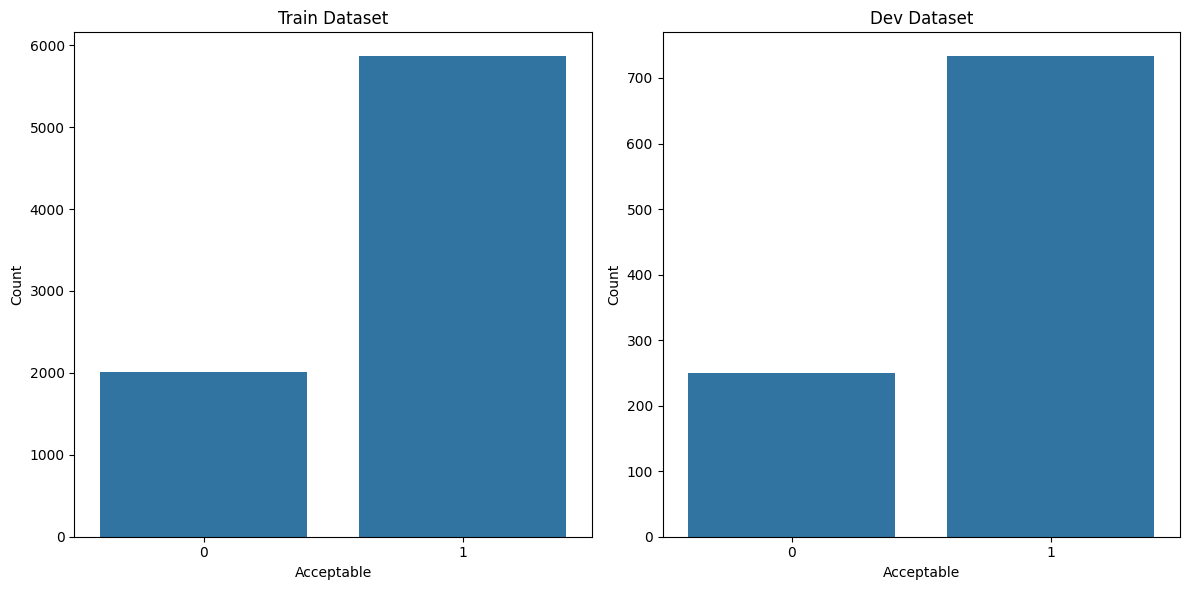

In [3]:
# Подсчёт количества значений целевой переменной в каждом датасете
train_counts = train_df['acceptable'].value_counts()
dev_counts = dev_df['acceptable'].value_counts()

# Построение графиков
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# График для train_df
sns.barplot(x=train_counts.index, y=train_counts.values, ax=axs[0])
axs[0].set_title('Train Dataset')
axs[0].set_xlabel('Acceptable')
axs[0].set_ylabel('Count')

# График для dev_df
sns.barplot(x=dev_counts.index, y=dev_counts.values, ax=axs[1])
axs[1].set_title('Dev Dataset')
axs[1].set_xlabel('Acceptable')
axs[1].set_ylabel('Count')

# Отображение графиков
plt.tight_layout()
plt.show()

Выполним небольшой чит-код по сокращению количества данных в датасетах, чтобы ускорить процесс обучения.

Уменьшим количество записей в даттасете <b>in_domain_dev.csv</b>.

In [4]:
class_counts = dev_df['acceptable'].value_counts()
print(class_counts)

acceptable
1    733
0    250
Name: count, dtype: int64


In [5]:
# Количество строк класса 1, которые нужно удалить
rows_to_drop = 233
# rows_to_drop = 483

# Выбор рандомных строк класса 1 для удаления
if class_counts[1] > rows_to_drop:
    # Получение индексов рандомных строк класса 1
    random_indices = dev_df[dev_df['acceptable'] == 1].sample(n=rows_to_drop, random_state=42).index
    
    # Удаление выбранных строк из DataFrame
    dev_df = dev_df.drop(random_indices)

    # Проверка нового количества записей по каждому классу
    new_class_counts = dev_df['acceptable'].value_counts()
    print(new_class_counts)
else:
    print("Невозможно удалить такое количество строк, так как количество строк класса 1 меньше указанного.")

acceptable
1    500
0    250
Name: count, dtype: int64


In [6]:
# Количество строк класса 1 и класса 0, которые нужно удалить
rows_to_drop = 150
# rows_to_drop = 249

# Выбор рандомных строк для удаления
if class_counts[1] >= rows_to_drop and class_counts[0] >= rows_to_drop:
    # Получение индексов рандомных строк класса 1
    random_indices_class_1 = dev_df[dev_df['acceptable'] == 1].sample(n=rows_to_drop, random_state=42).index
    # Получение индексов рандомных строк класса 0
    random_indices_class_0 = dev_df[dev_df['acceptable'] == 0].sample(n=rows_to_drop, random_state=42).index
    
    # Объединение индексов строк для удаления
    rows_to_drop_indices = random_indices_class_1.union(random_indices_class_0)
    
    # Удаление выбранных строк из DataFrame
    dev_df = dev_df.drop(rows_to_drop_indices)

    # Проверка нового количества записей по каждому классу
    new_class_counts = dev_df['acceptable'].value_counts()
    print(new_class_counts)
else:
    print("Невозможно удалить такое количество строк, так как количество строк в одном из классов меньше указанного.")

acceptable
1    350
0    100
Name: count, dtype: int64


Уменьшим количество записей в даттасете <b>in_domain_train.csv</b>.

In [7]:
class_counts = train_df['acceptable'].value_counts()
print(class_counts)

acceptable
1    5864
0    2005
Name: count, dtype: int64


In [8]:
# Количество строк класса 1, которые нужно удалить
rows_to_drop = 1859
# rows_to_drop = 3859

# Выбор рандомных строк класса 1 для удаления
if class_counts[1] > rows_to_drop:
    # Получение индексов рандомных строк класса 1
    random_indices = train_df[train_df['acceptable'] == 1].sample(n=rows_to_drop, random_state=42).index
    
    # Удаление выбранных строк из DataFrame
    train_df = train_df.drop(random_indices)

    # Проверка нового количества записей по каждому классу
    new_class_counts = train_df['acceptable'].value_counts()
    print(new_class_counts)
else:
    print("Невозможно удалить такое количество строк, так как количество строк класса 1 меньше указанного.")

acceptable
1    4005
0    2005
Name: count, dtype: int64


In [9]:
# Количество строк класса 1 и класса 0, которые нужно удалить
rows_to_drop = 1205
# rows_to_drop = 2004

# Выбор рандомных строк для удаления
if class_counts[1] >= rows_to_drop and class_counts[0] >= rows_to_drop:
    # Получение индексов рандомных строк класса 1
    random_indices_class_1 = train_df[train_df['acceptable'] == 1].sample(n=rows_to_drop, random_state=42).index
    # Получение индексов рандомных строк класса 0
    random_indices_class_0 = train_df[train_df['acceptable'] == 0].sample(n=rows_to_drop, random_state=42).index
    
    # Объединение индексов строк для удаления
    rows_to_drop_indices = random_indices_class_1.union(random_indices_class_0)
    
    # Удаление выбранных строк из DataFrame
    train_df = train_df.drop(rows_to_drop_indices)

    # Проверка нового количества записей по каждому классу
    new_class_counts = train_df['acceptable'].value_counts()
    print(new_class_counts)
else:
    print("Невозможно удалить такое количество строк, так как количество строк в одном из классов меньше указанного.")

acceptable
1    2800
0     800
Name: count, dtype: int64


<b> Зафайнтьюним и протестируем RuBert на данной задаче. Возьмём предобученную модель RuBert с сайта huggingface - ruBert-large - https://huggingface.co/sberbank-ai/ruBert-large.</b>

In [10]:
# Переименование столбца 'acceptable' в 'labels'
train_df_RB = train_df.rename(columns={'acceptable': 'labels'})
dev_df_RB = dev_df.rename(columns={'acceptable': 'labels'})

# Удаление индекса из датафреймов
train_df_RB = train_df_RB.reset_index(drop=True)
dev_df_RB = dev_df_RB.reset_index(drop=True)

# Подготовка данных
train_data = Dataset.from_pandas(train_df_RB[['sentence', 'labels']])
test_data = Dataset.from_pandas(dev_df_RB[['sentence', 'labels']])

# Загрузка токенизатора и модели
base_model = 'sberbank-ai/ruBert-large'
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=2)

# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True, max_length=512)

train_data = train_data.map(tokenize_function, batched=True, remove_columns=['sentence'])
test_data = test_data.map(tokenize_function, batched=True, remove_columns=['sentence'])

# Создание DataLoader'ов
collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=4, collate_fn=collator)
val_dataloader = DataLoader(test_data, shuffle=False, batch_size=4, collate_fn=collator)

# Настройка модели и оптимизатора
if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Обучение модели и оценка после каждой эпохи
for epoch in trange(5, desc="Epoch"):
    # Обучение модели
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader, desc="Training"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.item())
    
    train_loss = np.mean(train_losses)
    
    # Оценка модели
    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = {k: v.to(model.device) for k, v in batch.items()}
        with torch.no_grad():
            out = model(**batch)
            eval_losses.append(out.loss.item())
            eval_preds.extend(out.logits.argmax(1).tolist())
            eval_targets.extend(batch['labels'].tolist())
    
    eval_loss = np.mean(eval_losses)
    eval_accuracy = accuracy_score(eval_targets, eval_preds)
    
    # Вывод результатов за эпоху
    print(f"Epoch {epoch+1}/{5}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {eval_loss:.4f}")
    print(f"Validation Accuracy: {eval_accuracy:.4f}")

# Финальная оценка модели
eval_losses = []
eval_preds = []
eval_targets = []
model.eval()
for batch in tqdm(val_dataloader, desc="Final Evaluation"):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        out = model(**batch)
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())

final_eval_loss = np.mean(eval_losses)
final_eval_accuracy = accuracy_score(eval_targets, eval_preds)

print('Final Eval_loss:', final_eval_loss)
print('Final Eval_accuracy:', final_eval_accuracy)

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/900 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/5
Training Loss: 0.5385
Validation Loss: 0.5026
Validation Accuracy: 0.7778


Training:   0%|          | 0/900 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2/5
Training Loss: 0.4950
Validation Loss: 0.4803
Validation Accuracy: 0.7778


Training:   0%|          | 0/900 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3/5
Training Loss: 0.4419
Validation Loss: 0.4703
Validation Accuracy: 0.7933


Training:   0%|          | 0/900 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4/5
Training Loss: 0.3635
Validation Loss: 0.4868
Validation Accuracy: 0.8067


Training:   0%|          | 0/900 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5/5
Training Loss: 0.2637
Validation Loss: 0.5788
Validation Accuracy: 0.8022


Final Evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

Final Eval_loss: 0.5788463041994029
Final Eval_accuracy: 0.8022222222222222


<b>Возьмём RuGPT3 large и решим данное задание с помощью методов few-shot.</b>

In [10]:
# Выбор модели и токенизатора
model_name = "ai-forever/rugpt3large_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Функция для токенизации данных
def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=128)

# Подготовка данных для обучения и тестирования
train_dfset = Dataset.from_pandas(train_df)
train_dfset = train_dfset.map(tokenize_function, batched=True)
train_dfset = train_dfset.rename_column("acceptable", "labels")
train_dfset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dev_dataset = Dataset.from_pandas(dev_df)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.rename_column("acceptable", "labels")
dev_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Загрузка модели для классификации
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # num_labels=2 - количество классов=2

# Настройка аргументов тренировки
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    num_train_epochs=5,
    overwrite_output_dir=True,
    report_to="tensorboard",
)

# Функция для оценки модели
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
    }

# Инициализация трейнера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dfset,
    eval_dataset=dev_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Обучение модели
trainer.train()

# Оценка модели на тестовом наборе
eval_results = trainer.evaluate()

# Вывод результатов оценки
print(eval_results)

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

{'loss': 0.8401, 'grad_norm': 0.5966641902923584, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.1111111111111111}
{'loss': 0.6001, 'grad_norm': 10.104169845581055, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.2222222222222222}
{'loss': 0.5856, 'grad_norm': 7.7971391677856445, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.3333333333333333}
{'loss': 0.5531, 'grad_norm': 1.2665376663208008, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.4444444444444444}
{'loss': 0.5548, 'grad_norm': 4.187890529632568, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.5555555555555556}
{'loss': 0.5543, 'grad_norm': 1.069111943244934, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.6666666666666666}
{'loss': 0.5598, 'grad_norm': 1.741490125656128, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.7777777777777778}
{'loss': 0.604, 'grad_norm': 6.570312976837158, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.8888888888888888}
{'loss': 0.5422, 'grad_norm': 1.1055327653884888, 

<b>Обучим и протестируем модель RuT5 на данной задаче (за пример finetun’а взят код здесь: https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_t5.py)</b>

In [11]:
# Загрузка метрик
ACCURACY = evaluate.load("accuracy")
MODEL_TO_HUB_NAME = {
    "t5-base": "sberbank-ai/ruT5-base",
    "t5-large": "sberbank-ai/ruT5-large",
}

os.environ["TOKENIZERS_PARALLELISM"] = "false"

WEIGHT_DECAY = 0
N_EPOCHS = 5
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
SEED = 42

POS_LABEL = "yes"
NEG_LABEL = "no"

def compute_metrics(p, tokenizer):
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if prediction == POS_LABEL else 0 for prediction in string_preds]

    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    int_labels = []

    for string_label in string_labels:
        if string_label == POS_LABEL:
            int_labels.append(1)
        elif string_label == NEG_LABEL or string_label == "":  # second case accounts for test data
            int_labels.append(0)
        else:
            raise ValueError()

    acc_result = ACCURACY.compute(predictions=int_preds, references=int_labels)
    result = {"accuracy": acc_result["accuracy"],}

    return result

def preprocess_examples(examples, tokenizer):
    result = tokenizer(examples["sentence"], padding=False)

    if "acceptable" in examples:
        label_sequences = []
        for label in examples["acceptable"]:
            if label == 1:
                target_sequence = POS_LABEL
            elif label == 0:
                target_sequence = NEG_LABEL
            else:
                raise ValueError("Unknown class label")
            label_sequences.append(target_sequence)
    else:
        # a hack to avoid the "You have to specify either decoder_input_ids or decoder_inputs_embeds" error
        # for test data
        label_sequences = ["" for _ in examples["sentence"]]

    result["labels"] = tokenizer(label_sequences, padding=False)["input_ids"]
    result["length"] = [len(list(tokenize(sentence))) for sentence in examples["sentence"]]
    return result

def read_splits(as_datasets=False):
    if as_datasets:
        train_dfset = Dataset.from_pandas(train_df)
        dev_dataset = Dataset.from_pandas(dev_df)
        return {"train": train_dfset, "dev": dev_dataset}
    else:
        return train_df, dev_df

model_name = "t5-base"  # или "t5-large"

tokenizer = T5Tokenizer.from_pretrained(MODEL_TO_HUB_NAME[model_name])
splits = read_splits(as_datasets=True)

# Применение функции preprocess_examples к каждому элементу словаря
tokenized_splits = {
    key: value.map(partial(preprocess_examples, tokenizer=tokenizer), batched=True, remove_columns=["sentence"])
    for key, value in splits.items()
}

data_collator = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8)

model = T5ForConditionalGeneration.from_pretrained(MODEL_TO_HUB_NAME[model_name])

run_base_dir = f"{model_name}_{LEARNING_RATE}_{WEIGHT_DECAY}_{BATCH_SIZE}"

training_args = Seq2SeqTrainingArguments(
    output_dir=f"checkpoints/{run_base_dir}",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=N_EPOCHS,
    lr_scheduler_type="constant",
    save_strategy="epoch",
    save_total_limit=1,
    seed=SEED,
    fp16=True,
    dataloader_num_workers=4,
    group_by_length=True,
    report_to="none",
    load_best_model_at_end=True,
    optim="adafactor",
    predict_with_generate=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_splits["train"],
    eval_dataset=tokenized_splits["dev"],
    compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
    tokenizer=tokenizer,
    data_collator=data_collator,
)

train_result = trainer.train()
print(f"{run_base_dir}_{SEED}")
print("train", train_result.metrics)

os.makedirs(f"results/{run_base_dir}_{SEED}", exist_ok=True)

dev_predictions = trainer.predict(
    test_dataset=tokenized_splits["dev"], metric_key_prefix="test", max_length=10
)
print("dev", dev_predictions.metrics)

predictions = trainer.predict(test_dataset=tokenized_splits["dev"], max_length=10)

string_preds = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

int_preds = [1 if prediction == POS_LABEL else 0 for prediction in string_preds]
int_preds = np.asarray(int_preds)

np.save(f"results/{run_base_dir}_{SEED}/preds.npy", int_preds)

rmtree(f"checkpoints/{run_base_dir}")

os.makedirs("results_agg", exist_ok=True)
np.save(f"results_agg/{model_name}_dev.npy", np.array([[dev_predictions.metrics["test_accuracy"],]]))

Map:   0%|          | 0/3600 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

{'eval_loss': 0.20055700838565826, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 33.2342, 'eval_samples_per_second': 13.54, 'eval_steps_per_second': 0.12, 'epoch': 1.0}
{'eval_loss': 0.1978120058774948, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 33.1919, 'eval_samples_per_second': 13.558, 'eval_steps_per_second': 0.121, 'epoch': 2.0}
{'eval_loss': 0.20033080875873566, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 33.0539, 'eval_samples_per_second': 13.614, 'eval_steps_per_second': 0.121, 'epoch': 3.0}
{'eval_loss': 0.19990453124046326, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 33.0723, 'eval_samples_per_second': 13.607, 'eval_steps_per_second': 0.121, 'epoch': 4.0}
{'eval_loss': 0.2198890894651413, 'eval_accuracy': 0.7777777777777778, 'eval_runtime': 33.0883, 'eval_samples_per_second': 13.6, 'eval_steps_per_second': 0.121, 'epoch': 5.0}
{'train_runtime': 420.9455, 'train_samples_per_second': 42.761, 'train_steps_per_second': 0.344, 'train_loss': 0.801

<b>Результаты.</b>

In [10]:
import pandas as pd
result = {
    'Model': ['RuBert', 'RuGPT3', 'RuT5'],
    'Loss': [0.5788, 1.1302, 0.1978],
    'Accuracy': [0.8022, 0.7578, 0.7778]
}

df_result = pd.DataFrame(result)
df_result

,Model,Loss,Accuracy
0,RuBert,0.5788,0.8022
1,RuGPT3,1.1302,0.7578
2,RuT5,0.1978,0.7778


<b>RuBert:</b> Модель RuBert демонстрирует хорошее значение accuracy (80.22%) при сравнительно невысоком значении loss (0.5788). Это указывает на то, что модель хорошо справляется с задачей, обеспечивая хорошее качество предсказаний.
<br><b>RuGPT3:</b> Модель RuGPT3 имеет наибольшее значение loss (1.1302) среди всех моделей, что указывает на большую степень ошибок в предсказаниях. Значение accuracy (75.78%) также самое низкое, что говорит о том, что RuGPT3 работает хуже по сравнению с другими моделями в данном контексте.
<br><b>RuT5:</b> Модель RuT5 показывает самое низкое значение loss (0.1978), что свидетельствует о минимальных ошибках в предсказаниях. Однако значение accuracy (77.78%) ниже, чем у RuBert, но выше, чем у RuGPT3. Это указывает на то, что RuT5 делает меньше ошибок, но может не так хорошо улавливать паттерны данных, как RuBert.

<b>Общие выводы:</b>
* RuBert и RuT5 показывают лучшие результаты по сравнению с RuGPT3.
* RuBert демонстрирует наилучший баланс между низким значением loss и высоким значением accuracy, что делает его наиболее предпочтительной моделью из трёх для данной задачи.
* RuT5 имеет наименьшее значение loss, что говорит о высокой точности предсказаний, но немного уступает RuBert в общем качестве.
* RuGPT3 показывает наихудшие результаты по обоим параметрам, что указывает на необходимость улучшений или замены модели для достижения лучших результатов.